# [E-07] 인물 사진을 만들어 보자

* 루브릭 평가기준
    * 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키 사진을 각각 1장 이상 성공적으로 제작하였다.
    * 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
    * 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

### 필요한 라이브러리 및 이미지 준비

In [1]:
import os
import urllib     # 웹에서 데이터를 다운로드할 때 사용
import cv2    # opencv 라이브러리로 이미지를 처리할 때
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

* 알게된 것
    * pixellib: 픽셀 단위로 객체를 추출하는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

(800, 800, 3)


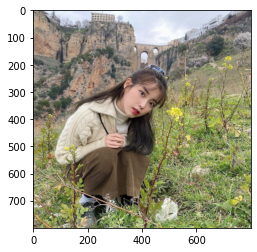

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 

* 세그멘테이션이란?
    * 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션이라고 한다.
    * 모든 픽셀에 라벨을 할당하고 같은 라벨은 **'공통적인 특징'**을 가진다고 가정한다.


In [3]:
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f4ca03e71c0>)

In [4]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# pascal voc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

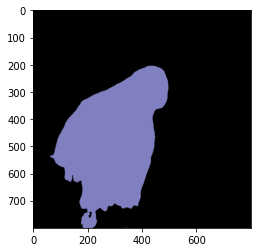

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [10]:
# output에 어떤 색상으로 나타나 있는지 확인
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]

array([192, 128, 128])

In [12]:
# output 이미지는 BGR 순서로 채널 배치가 되어 있고, colormap은 RGB 순서기 때문에 바꿔줘야함
seg_color = (128,128,192)

(800, 800)


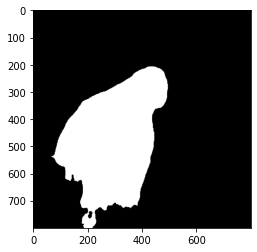

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

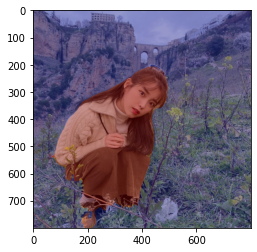

In [14]:
img_show = img_orig.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask = seg_map.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 7-5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기

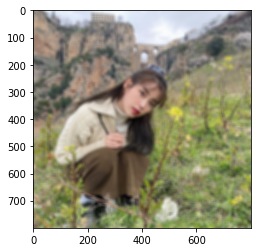

In [15]:
img_orig_blur = cv2.blur(img_orig, (13, 13))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

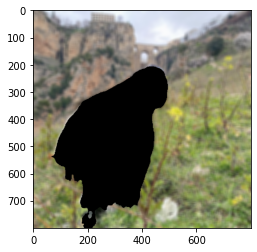

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출한다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* bitwise_not
    * 이미지가 반전된다.
    * 원래 마스크에서는 배경이 0, 사람이 255였으니까 bitwise_not 연산 후엔 배경이 255, 사람이 0이 된다.

## 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

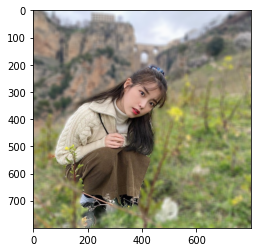

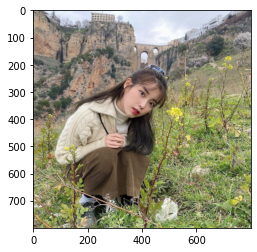

In [17]:
# 흐려진 배경과 사람을 합친다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

* np.where 메서드로 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고, 아닌 영역은 blur된 이미지 값을 사용한다.
* np.where(조건, 참일때, 거짓일때)

## 7-7. 프로젝트: 인물 모드 문제점 찾기

### 인물모드 직접해보기

In [18]:
import os
import urllib     # 웹에서 데이터를 다운로드할 때 사용
import cv2    # opencv 라이브러리로 이미지를 처리할 때
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1440, 1080, 3)


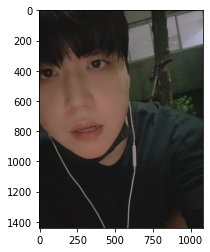

(1440, 1080, 3)


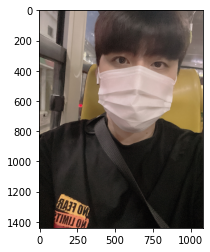

(960, 719, 3)


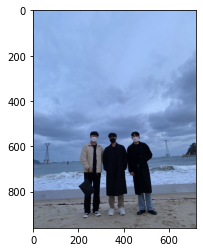

In [19]:
# 셀카
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/photo1.png'  
img_orig1 = cv2.imread(img_path1) 

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/photo2.png'  
img_orig2 = cv2.imread(img_path2) 

img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/photo3.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig1.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f4bc7b84730>)

In [21]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [22]:
# 모델에 이미지 입력
segvalues1, output1 = model.segmentAsPascalvoc(img_path1)
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

In [23]:
# pascal voc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

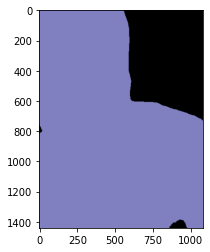

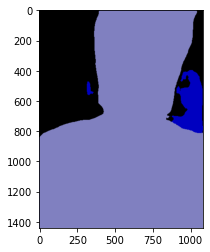

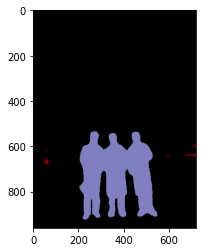

In [24]:
plt.imshow(output1)
plt.show()

plt.imshow(output2)
plt.show()

plt.imshow(output3)
plt.show()

In [25]:
segvalues1

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [26]:
segvalues2

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [27]:
segvalues3

{'class_ids': array([ 0,  4, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [28]:
for class_id1 in segvalues1['class_ids']:
    print(LABEL_NAMES[class_id1])

background
person
pottedplant


In [29]:
for class_id2 in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id2])

background
chair
person


In [30]:
for class_id3 in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id3])

background
boat
person


In [31]:
# output에 어떤 색상으로 나타나 있는지 확인
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [32]:
colormap[15]

array([192, 128, 128])

In [33]:
# output 이미지는 BGR 순서로 채널 배치가 되어 있고, colormap은 RGB 순서기 때문에 바꿔줘야함
seg_color = (128,128,192)

(800, 800)


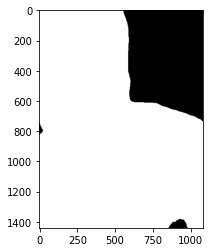

(800, 800)


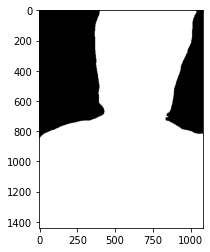

(800, 800)


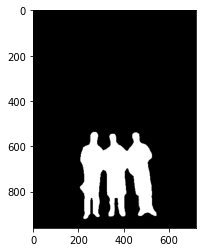

In [34]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map1 = np.all(output1==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map1, cmap='gray')
plt.show()

seg_map2 = np.all(output2==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

seg_map3 = np.all(output3==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map3, cmap='gray')
plt.show()

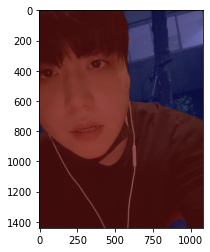

In [35]:
# 1번 이미지
img_show1 = img_orig1.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask1 = seg_map1.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

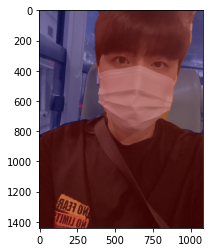

In [36]:
# 2번 이미지
img_show2 = img_orig2.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

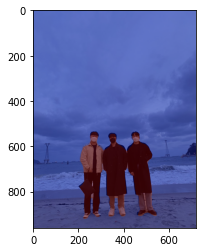

In [37]:
# 3번 이미지
img_show3 = img_orig3.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask3 = seg_map3.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

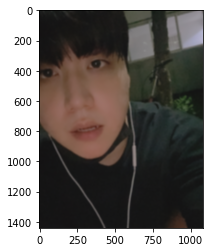

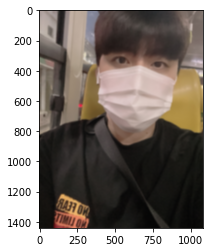

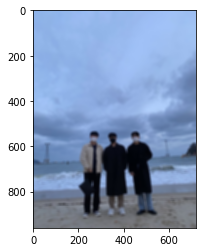

In [38]:
img_orig_blur1 = cv2.blur(img_orig1, (13, 13))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur2 = cv2.blur(img_orig2, (13, 13))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur3 = cv2.blur(img_orig3, (13, 13))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

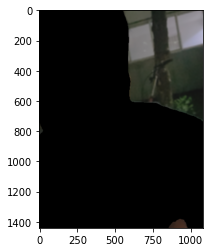

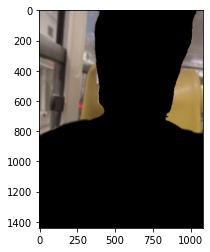

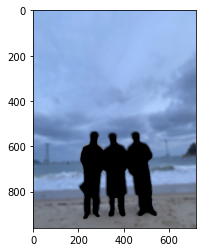

In [39]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출한다.
img_mask_color1 = cv2.cvtColor(img_mask1, cv2.COLOR_GRAY2BGR)
img_bg_mask1 = cv2.bitwise_not(img_mask_color1)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

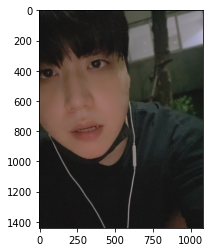

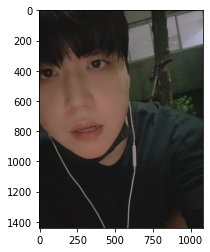

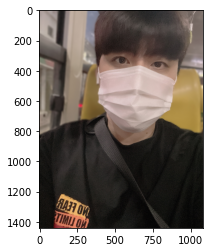

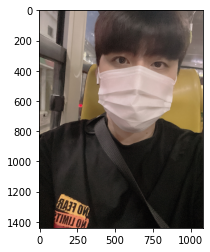

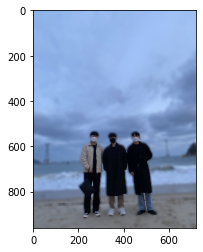

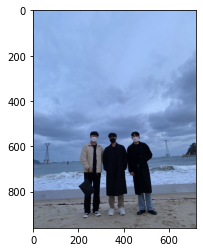

In [40]:
# 흐려진 배경과 사람을 합친다.
# 1
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)

plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

# 2
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)

plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

# 3
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

(427, 640, 3)


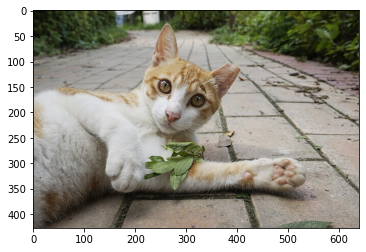

In [41]:
# 고양이 사진
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig_cat = cv2.imread(img_path_cat) 

print(img_orig_cat.shape)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f4bc4b7e310>)

In [43]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [44]:
# 모델에 이미지 입력
segvalues_cat, output_cat = model.segmentAsPascalvoc(img_path_cat)

In [45]:
# pascal voc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

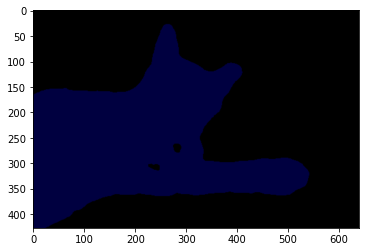

In [46]:
plt.imshow(output_cat)
plt.show()

In [47]:
segvalues_cat

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [48]:
for class_id_cat in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id_cat])

background
cat


In [49]:
# output에 어떤 색상으로 나타나 있는지 확인
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [50]:
colormap[8]

array([64,  0,  0])

In [51]:
# output 이미지는 BGR 순서로 채널 배치가 되어 있고, colormap은 RGB 순서기 때문에 바꿔줘야함
seg_color = (0,0,64)

(427, 640)


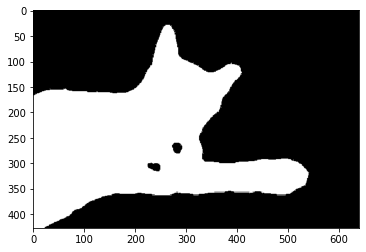

In [52]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map_cat = np.all(output_cat==seg_color, axis=-1)
print(seg_map_cat.shape)
plt.imshow(seg_map_cat, cmap='gray')
plt.show()

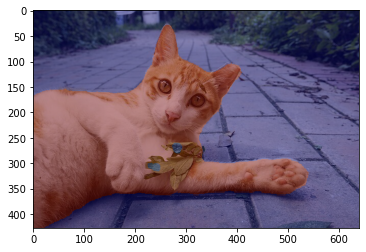

In [53]:
img_show_cat = img_orig_cat.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask_cat = seg_map_cat.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

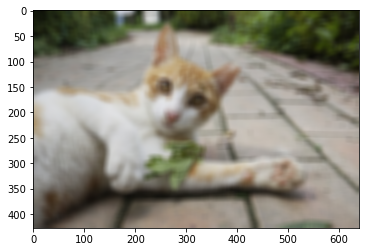

In [54]:
img_orig_blur_cat = cv2.blur(img_orig_cat, (13, 13))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

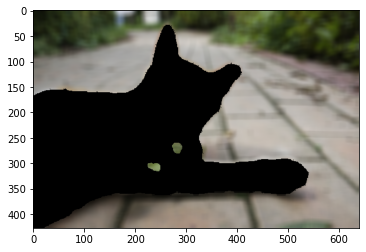

In [55]:
img_mask_color_cat = cv2.cvtColor(img_mask_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_orig_blur_cat, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

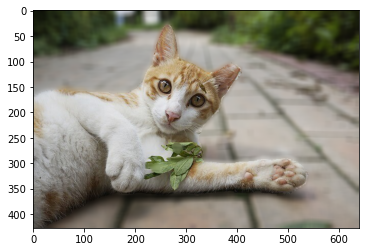

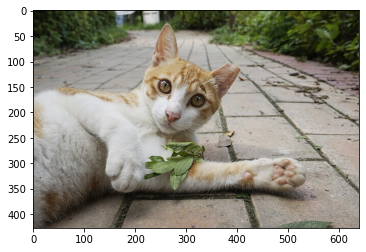

In [56]:
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, img_bg_blur_cat)

plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.show()

(960, 719, 3)


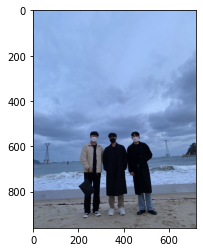

In [94]:
# 배경 사진 바꿔보기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/photo3.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [95]:
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f4ca00c25e0>)

In [96]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [97]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [98]:
# pascal voc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

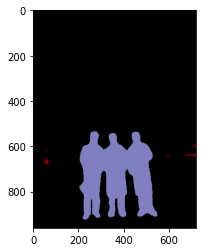

In [99]:
plt.imshow(output)
plt.show()

In [100]:
segvalues

{'class_ids': array([ 0,  4, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [101]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
boat
person


In [102]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [103]:
colormap[15]

array([192, 128, 128])

In [104]:
seg_color = (128,128,192)

(960, 719)


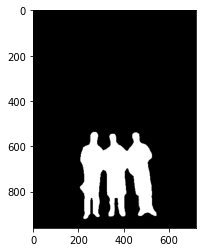

In [105]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

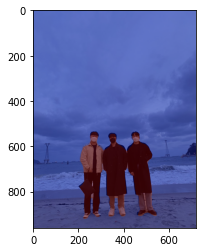

In [106]:
img_show = img_orig.copy()

# True, False 값을 각각 255와 0으로 나눠준다. -> 정규화?
img_mask = seg_map.astype(np.uint8) * 255

# 255, 0을 적당한 색으로 바꾼다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.4, 0.6은 두 이미지를 섞는 비율임
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

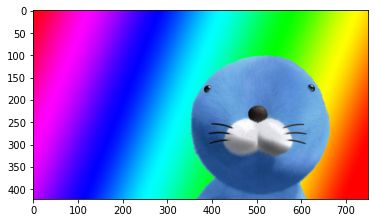

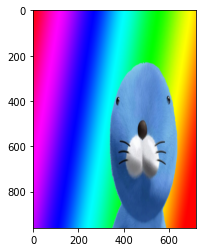

In [122]:
bono = os.getenv('HOME') + '/aiffel/human_segmentation/images/bono.png'
bono_orig = cv2.imread(bono)

plt.imshow(cv2.cvtColor(bono_orig, cv2.COLOR_BGR2RGB))
plt.show()

bono_resize = cv2.resize(bono_orig,(719,960), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(bono_resize, cv2.COLOR_BGR2RGB))
plt.show()

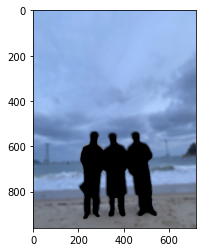

In [123]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

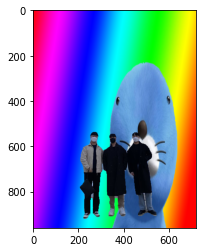

In [124]:
img_concat = np.where(img_mask_color==255, img_orig, bono_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지 사이즈가 달라 합성이 안됐음: resize

### 사진에서 문제점 찾기

* 첫 번째, 어두울 경우 blur 효과가 뚜렷해 보이지 않는 것 같다.

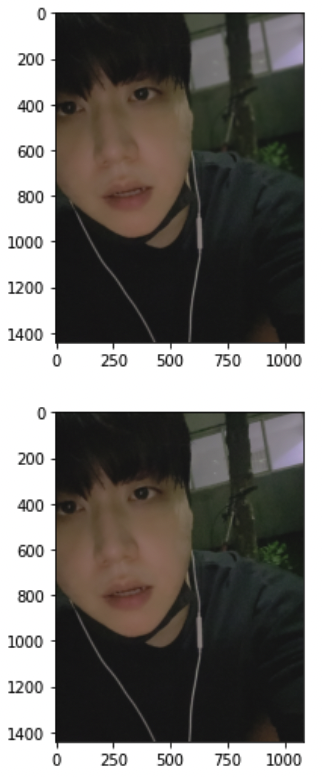

위 두 사진에서 blur효과가 들어간 위 사진과 일반 사진의 차이가 크게 나지 않아보인다. 원인으로 생각해볼 수 있는 건 시간대가 밤이어서 어두웠다는 점 또는 인물이 이미지 상 대부분을 차지하고 있기 때문이 아닐까 생각해봤는데, 이 이미지 다음으로 blur를 적용한 사진도 인물이 이미지의 대부분을 차지 하고 있었지만 이 이미지보다는 blur 효과가 명확하게 보였다. 

- - -

* 두 번째, 이미지에서 세그멘테이션하고자 하는 대상이 작을 경우 영역의 구분이 명확하지가 않다.

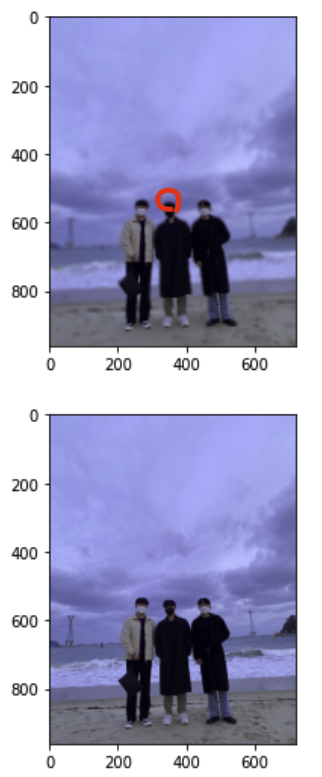

위 두 사진 중 위의 이미지를 보면 영역의 구분이 명확하지가 않다. 생각해볼 수 있는 원인으로 구분하고자 하는 이미지의 크기가 너무 작아서 세그멘테이션할 때 명확하게 구분이 되지 않은 것이 아닌가 생각한다.

- - -

* 세그멘테이션으로 추출한 객체에 다른 요소가 섞여있을 때 해당 요소는 영역 구분이 되지 않는데, blur 처리가 이상하게 된다.

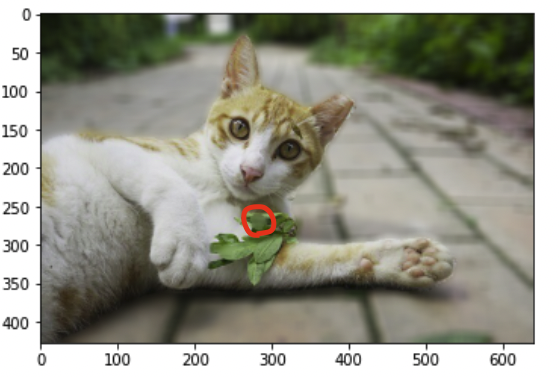

위 사진을 보면 고양이 다리 부분에 있는 나뭇잎은 고양이가 아니지만 세그멘테이션 영역에 포함되어 있으므로 blur 효과를 줄 때 나뭇잎 대부분이 보인다. 그런데 중간에 작게 원 모양으로 blur 처리가 된 것을 확인할 수 있다. 시맨틱 세그멘테이션으로 고양이 객체를 인식할 때 나뭇잎을 완전히 인식하지 못한 것이 원인으로 생각된다.

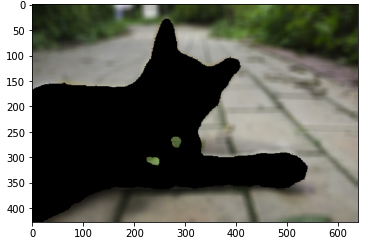

위 이미지를 보면 두 군데 세그멘테이션을 하지 못한 부분을 확인할 수 있다.

### 해결 방법을 생각해 보기 전에

* 들어가기 전에 이미지를 다루거나 이미지에 대한 사전 지식을 정리해보면,

* 아웃포커싱이란
    * 초점이 맞은 피사체 외에 배경을 흐릿하게 보이도록 하는 기술을 뜻한다.


* 얕은 피사계 심도
    * 하나의 점을 강조하고 나머지 내용에 부드러운 흐림 효과를 줌으로써 어떤 부분을 강조할 수 있다. 
    * 한국에서는 주로 아웃포커싱이라는 용어를 사용하지만 정확한 표현은 **얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)라고 한다.**

* 이미지 센서
    * 빛을 디지털 신호로 변환해 이미지로 구현하는 역할을 하는 반도체인데, 현재는 스마트폰이 수요의 대부분을 차지하고 있지만, 자율주행 자동차와 같은 분야에서도 많은 수요가 예측된다.
    * 최근에는 3D 이미지 센서가 각광 받고 있음. 기존에는 2D 이미지만 구현할 수 있었지만, 3D 이미지 센서는 사물까지의 거리(심도)를 측정함으로써 더 정밀하게 물체나 동작을 인식해 이를 3D 이미지로 구현할 수 있다.

* 해결 방법을 생각해보기 전에 세그멘테이션은 어떤 한계를 가지고 있는가를 정리해보면, 
    * 어두운 사진일 경우 blur 효과가 명확하게 구분이 될 정도로 적용되지 않는다.
    * 인식한 대상이 크기가 작거나 경계가 명확하지 않은 경우 경계선 부분에 blur 효과가 침범할 수 있다.
    * 인식 대상이 나뭇잎이나 다른 물건을 들고 있거나 섞여있을 경우 해당 부분에 blur가 적용될 수 있다.

### 해결 방법 생각해보기

이번 노드를 진행하면서 문제라고 생각했던 부분에 대해 해결 방법을 생각해보면,

* 어두운 사진, 즉 조도가 낮은 사진과 인식한 대상의 크기가 작거나 하는 이미지에 blur와 같은 효과를 적용할 때, 카메라와 피사체의 거리를 판단할 수 있는 센서(3D 이미지 센서 등)과 같은 기술을 활용해 조금 더 명확하게 피사체를 인식하는 것이다. 다만 나는 이 기술을 활용하는 것에는 이의가 없지만 이미 찍혀있는 사진을 가지고 진행할 땐 어떻게 할까하는 의문이 생겼다. LiDAR 방식과 같이 대상과의 거리를 측정하는 방식을 활용해 피사체를 조금 더 정확하게 인식한다면 당연히 이미지에 다양한 효과를 줄 때 조금 더 명확하게 대상을 인식할 수 있을 것이지만, 내가 잘못 이해하고 있는 것인지 이미 일반 카메라로 찍은 이미지에도 이런 센서와 같은 방식으로 피사체의 거리를 인식해 명확한 인식이 가능한지는 잘 모르겠다. 

* 그리고 고양이 사진을 통해 알게된 문제, 인식 대상 안에 다른 물체가 섞여있을 경우에 대해서 생각해보면, 아직 내 수준에서 가능 여부를 모르기에 생각한 방법이지만 이전 노드에서 진행했던 detection을 활용하면 되지 않을까하는 생각이 들었다. face detection을 통해 이미지에서 얼굴을 찾았던 것과 같이 인식하고자 하는 대상이 아닌 물체를 따로 인식해 적용하면 되지 않을까 생각만 해봤다..만약 가능하다면 다른 물체를 인식하는 것이 아니어도 조금 더 명확한 세그멘테이션이 가능하지 않을까싶다.

### 회고

* 배경을 다른 이미지로 바꿔보는 단계 전까지는 잘 진행됐다. 모르는 메서드나 이론이 많았지만 아직까지는 pixellib와 같은 이미 만들어진 모델을 사용해 객체를 인식하는 정도여서 아, 인식을 하는구나 정도만 이해했다. 그런데 배경을 다른 이미지로 바꾸는 부분에서 처음에는 사이즈가 달라 오류가 났고, 다른 분의 github를 참고해 해결했다. 사이즈가 다른 두 이미지가 합쳐질까 의문이 있었지만 resize 메서드에 대해 모르기도 했고, 우선 해보자고 생각해 시도했지만 역시 실패했는데, 다른 분의 github에서 resize 코드에 대해 알게되어 다행이었다. 

* 세그멘테이션에 대해 알게 되었지만 정확히 어떤 원리인지, 어떻게 작동하는지 메커니즘에 대해서는 솔직히 아직 이해가 잘 안된다. 문제점은 보이지만 이게 문제가 맞는지, 문제가 맞다면 왜 발생했는지를 모르겠다. 또한 여전히 내가 이걸 코드로 작성할 수 있을까 걱정이 된다....

* 참고
    * https://github.com/youngchurl/EXPLORATION/blob/main/%5BE-07%5D%20Image%20Seperate/%5BE-07%5D%20Image%20seperate%20(1).ipynb